# A Level-2 Sea Ice Drift (SIED) algorithm for CIMR

This notebook implements a prototype for a Level-2 SIED algorithm for the CIMR mission.

We refer to the corresponding [ATBD](https://cimr-algos.github.io/SeaIceDrift_ATBD/intro.html) and especially the [Baseline Algorithm Definition](https://cimr-algos.github.io/SeaIceDrift_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition).

In particular, the figure below illustrates the overall concept of the processing:
<img src="https://cimr-algos.github.io/SeaIceDrift_ATBD/_images/CIMR_L2_Sea_Ice_Drift_Flow_Diagram.png" width="100%"/>

In [1]:
%load_ext cython

In [2]:
from importlib import reload

import sys
import os
import numpy as np
import xarray as xr
from netCDF4 import Dataset

from matplotlib import pylab as plt
import matplotlib.cm as cm
#import cmocean

from pyresample import parse_area_file
from datetime import datetime, timedelta

import shutil

# local modules contain software code that implement the SIED algorithm
if '/home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/src_sied/' not in sys.path:
    sys.path.insert(0, '/home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/src_sied/')
from src_sied import *#icedrift_wrapper, _idcore
from icedrift_wrapper import icedrift_wrapper

# prototype re-gridding toolbox to handle the L1B input
if '/home/emilyjd/cimr-devalgo/Tools/' not in sys.path:
    sys.path.insert(0, '/home/emilyjd/cimr-devalgo/Tools/')
from tools import io_handler as io
from tools import collocation as coll

# CMCC algorithm
#if '/home/emilyjd/sidrift_lowres/ice-tracking/src' not in sys.path:
#    sys.path.insert(0, '/home/emilyjd/sidrift_lowres/ice-tracking/src')
#import icedrift_wrapper

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rcParams.update({'font.size': 10})

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

## Parametrize the run

User-set parameters for the running of the whole notebook

In [4]:
code_dir = './src_sied'
area = 'nh'
algos = dict()
algos['KU'] = {'channels':('tb19v', 'tb19h'), 'target_band':'KU'}
algos['KA'] = {'channels':('tb37v', 'tb37h'), 'target_band':'KA'}

# Change location where you stored the L1B file
l1b_path = '/home/emilyjd/cimr-devalgo/data/L1B/'
# DEVALGO's simulated geometric test card
l1b_fn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
# DEVALGO's simulated radiometric test card
l1b_fn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'
#proj = 'nh'
hemi = 'nh'
dt = datetime.strptime('20230417T105425', '%Y%m%dT%H%M%S')

l1b_fn = os.path.join(l1b_path,l1b_fn)

# Icemask data and output locations
icemaskinput = '/home/emilyjd/cimr-devalgo/data/conc/ice_conc_nh_ease-125_reproc_202801101200.nc'
icemaskoutdir = '/home/emilyjd/cimr-devalgo/data/icemask'
icemaskgridfile = os.path.join(code_dir, 'grids_py.def')

pdate = datetime.strptime('20280110', '%Y%m%d')

## Step 1: Pre-processing (Icemask, loading the files, Laplacian pre-processing)


### Step 1a: Creating and regridding the ice mask


In [5]:
from src_sied import process_ice_mask
gridname = '{}-ease2-050'.format(hemi)
process_ice_mask.process_ice_mask(icemaskinput, icemaskoutdir, icemaskgridfile, gridname)

/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [6]:
# Reading in ice mask
icemaskname = os.path.join(icemaskoutdir, 'icemask-multi-{}-{}12.nc'.format(gridname, 
                                                                            datetime.strftime(pdate, '%Y%m%d')))
ie_data = Dataset(icemaskname, 'r')
ie = ie_data['ice_edge'][0, :, :]
#print("---", ie.shape)

Text(0.5, 1.0, 'Ice mask')

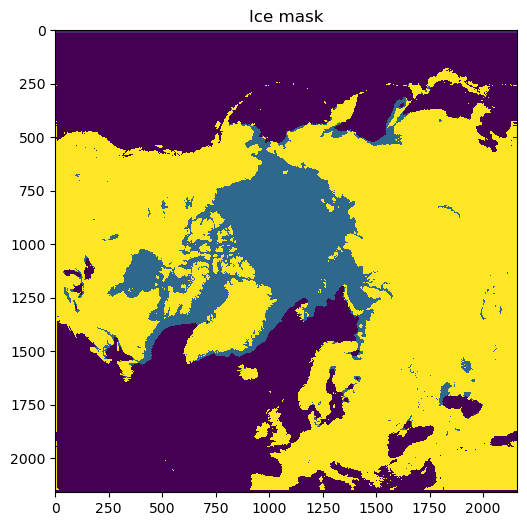

In [7]:
# Plotting the ice mask
cmap = cm.viridis
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1,1,1)
c1 = ax1.imshow(ie[:], interpolation = 'none', cmap=cmap)
ax1.set_title("Ice mask")

### Step 1b: Loading the data


In [8]:
# global definitions
tb_dict = {'tb01':'L','tb06':'C','tb10':'X','tb19':'KU','tb37':'KA',}
rev_tb_dict = {v:k for k,v in tb_dict.items()}
bands_needed = []
for alg in algos.keys():
    bands_needed += algos[alg]['channels']
bands_needed = list(set([tb_dict[b[:-1]] for b in bands_needed]))

In [9]:
# read L1B. We only read the bands needed
reload(io)
full_l1b = io.CIMR_L1B(l1b_fn, selected_bands=bands_needed, keep_calibration_view=True)

In [7]:
# align scalines using the scan angle offset
#full_l1b.align_arrays_to_start_at_zero_scan_angle()

# coarsen l1b samples along the scanlines with a kernel of 5 (horns are *not* combined)
#coarsen_l1b = full_l1b.coarsen_along_scanlines(kernel=5)
#/home/emilyjd/cimr-devalgo/test
# split into forward / backward scan
#fwd_l1b, bck_l1b = coarsen_l1b.split_forward_backward_scans(method='horn_scan_angle')

# reshape by interleaving the feeds 
#reshaped_fwd_l1b = fwd_l1b.reshape_interleave_feed()
#reshaped_bck_l1b = bck_l1b.reshape_interleave_feed()

# Collocate the channels with a nearest neighbour approach. This step covers both the
#   definition of the target grid, and the remapping. Use the correct 'target_band' for
#   each algorithm.
#fwd_l1x = dict()
#bck_l1x = dict()
#for alg in algos.keys():
#    fwd_l1x[alg] = coll.collocate_channels(reshaped_fwd_l1b.data, algos[alg]['target_band'], method='nn')
#    bck_l1x[alg] = coll.collocate_channels(reshaped_bck_l1b.data, algos[alg]['target_band'], method='nn')

In [10]:
# split into forward / backward scan
fwd_l1b, bck_l1b = full_l1b.split_forward_backward_scans(method='horn_scan_angle')



In [21]:
# TEST CELL ONLY - DELETE LATER
#print(fwd_l1b)
print("--", fwd_l1b.data['KU']['brightness_temperature_v'].shape)
print("--", fwd_l1b.data['KU']['brightness_temperature_v'])

-- (71, 3883, 8)
-- <xarray.DataArray 'brightness_temperature_v' (n_scans: 71,
                                              n_samples_earth: 3883, n_horns: 8)>
array([[[3.00027722e+02, 3.00027722e+02, 3.00027722e+02, ...,
         3.00027722e+02, 3.00027722e+02, 3.00027722e+02],
        [3.00027722e+02, 3.00027722e+02, 3.00027722e+02, ...,
         3.00027722e+02, 3.00027722e+02, 3.00027722e+02],
        [3.00027722e+02, 3.00027722e+02, 3.00027722e+02, ...,
         3.00027722e+02, 3.00027722e+02, 3.00027722e+02],
        ...,
        [3.10508288e-02, 3.10508288e-02, 3.10508288e-02, ...,
                    nan, 3.10508288e-02, 3.10508288e-02],
        [3.10508288e-02, 3.10508288e-02, 3.10508288e-02, ...,
                    nan, 3.10508288e-02, 3.10508288e-02],
        [3.10508288e-02, 3.10508288e-02, 3.10508288e-02, ...,
                    nan, 3.10508288e-02, 3.10508288e-02]],

       [[3.00027722e+02, 3.00027722e+02, 3.00027722e+02, ...,
         3.00027722e+02, 3.00027722e+02, 3

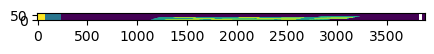

In [11]:
ku_v = fwd_l1b.data['KU']['brightness_temperature_v'][:, :, 0]

#cmap = cmocean.cm.ice
cmap = cm.viridis
fig = plt.figure(figsize=(5,5))
axF = fig.add_subplot(1,1,1)
cF = axF.imshow(ku_v, interpolation = 'none', origin='lower', cmap=cmap)


In [29]:
# TEST CELL ONLY - DELETE LATER

keylist = fwd_l1b.data['KU'].keys()
for k in keylist:
    print(k)

# Get lat/lon
print("--", fwd_l1b.data['KU'].keys())
print("--", fwd_l1b.data['KU']['lat'].data)
print("--", fwd_l1b.data['KU']['lon'].data)

time_earth
lon
lat
alt
OZA
scan_angle
instrument_status
sub_satellite_lat
sub_satellite_lon
satellite_position
satellite_velocity
Boresight2AntennaPlane
AntennaPlane2EarthFixed
ant_physical_temp_h
ant_physical_temp_v
reflector_temp_h
reflector_temp_v
feed_temp_h
feed_temp_v
wf_temp_h
wf_temp_v
switch_assembly_temp_h
switch_assembly_temp_v
brightness_temperature_h
brightness_temperature_v
brightness_temperature_t3
brightness_temperature_t4
receiver_temperature_h
receiver_temperature_v
receiver_temperature_t3
receiver_temperature_t4
x_h
x_v
acl_sky_h
acl_sky_v
orig_scan
orig_sample
orig_horn
horn_scan_angle
-- KeysView(<xarray.Dataset>
Dimensions:                    (n_scans: 71, n_samples_earth: 3883, n_horns: 8,
                                vector: 3, matrix: 9)
Dimensions without coordinates: n_scans, n_samples_earth, n_horns, vector,
                                matrix
Data variables: (12/39)
    time_earth                 (n_scans, n_samples_earth, n_horns) timedelta64[ns] ...

In [9]:
# TEST CELL ONLY - DELETE LATER

fwd_ku_lat = fwd_l1b.data['KU']['lat'].data
fwd_ku_lon = fwd_l1b.data['KU']['lon'].data
bck_ku_lat = bck_l1b.data['KU']['lat'].data
bck_ku_lon = bck_l1b.data['KU']['lon'].data
fwd_ka_lat = fwd_l1b.data['KA']['lat'].data
fwd_ka_lon = fwd_l1b.data['KA']['lon'].data
bck_ka_lat = bck_l1b.data['KA']['lat'].data
bck_ka_lon = bck_l1b.data['KA']['lon'].data

print(fwd_ku_lat.shape)

#assert(fwd_ku_lat == bck_ku_lat)

print(fwd_ku_lat[30:40,300:310, 0])
print(bck_ku_lat[30:40,300:310, 0])


(2205544,)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

### Step 1c: Regridding the data

In [12]:
reload(coll)

#TRY THIS:
#reshaped_fwd_l1b = fwd_l1b.reshape_interleave_feed()
#reshaped_bck_l1b = bck_l1b.reshape_interleave_feed()

# Reshaping
fwd_l1b_r = fwd_l1b.reshape_interleave_feed()
bck_l1b_r = bck_l1b.reshape_interleave_feed()

# Loading the grid information to get the lonlats
gridname = '{}-ease2-050'.format(hemi)
new_area_def = parse_area_file(icemaskgridfile, gridname)[0]
new_lons, new_lats = new_area_def.get_lonlats()

# Getting the input lat/lons
fwd_ku_lat = fwd_l1b_r.data['KU']['lat'].data#.ravel()
fwd_ku_lon = fwd_l1b_r.data['KU']['lon'].data#.ravel()
bck_ku_lat = bck_l1b_r.data['KU']['lat'].data#.ravel()
bck_ku_lon = bck_l1b_r.data['KU']['lon'].data#.ravel()
fwd_ka_lat = fwd_l1b_r.data['KA']['lat'].data#.ravel()
fwd_ka_lon = fwd_l1b_r.data['KA']['lon'].data#.ravel()
bck_ka_lat = bck_l1b_r.data['KA']['lat'].data#.ravel()
bck_ka_lon = bck_l1b_r.data['KA']['lon'].data#.ravel()
#swath_fwd_ku = SwathDefinition(lons=fwd_ku_lon, lats=fwd_ku_lat)
#swath_bck_ku = SwathDefinition(lons=bck_ku_lon, lats=bck_ku_lat)
#swath_fwd_ka = SwathDefinition(lons=fwd_ka_lon, lats=fwd_ka_lat)
#swath_bck_ka = SwathDefinition(lons=bck_ka_lon, lats=bck_ka_lat)

what = ('brightness_temperature_v', 'brightness_temperature_h')
fwd_ku_stack_shape = tuple(list(fwd_ku_lat.shape) + [len(what),])
bck_ku_stack_shape = tuple(list(bck_ku_lat.shape) + [len(what),])
fwd_ka_stack_shape = tuple(list(fwd_ka_lat.shape) + [len(what),])
bck_ka_stack_shape = tuple(list(bck_ka_lat.shape) + [len(what),])
fwd_ku_stack = np.empty(fwd_ku_stack_shape)
bck_ku_stack = np.empty(bck_ku_stack_shape)
fwd_ka_stack = np.empty(fwd_ka_stack_shape)
bck_ka_stack = np.empty(bck_ka_stack_shape)
for iw, w in enumerate(what):
    fwd_ku_stack[...,iw] = fwd_l1b_r.data['KU'][w].data
    bck_ku_stack[...,iw] = bck_l1b_r.data['KU'][w].data
    fwd_ka_stack[...,iw] = fwd_l1b_r.data['KA'][w].data
    bck_ka_stack[...,iw] = bck_l1b_r.data['KA'][w].data

print(fwd_ku_stack.shape)

params = {'method':'gauss', 'sigmas':25000, 'neighbours':55}
fwd_ku_regrid = coll._regrid_fields(new_lons, new_lats, fwd_ku_lon, fwd_ku_lat, fwd_ku_stack)
bck_ku_regrid = coll._regrid_fields(new_lons, new_lats, bck_ku_lon, bck_ku_lat, bck_ku_stack)
fwd_ka_regrid = coll._regrid_fields(new_lons, new_lats, fwd_ka_lon, fwd_ka_lat, fwd_ka_stack)
bck_ka_regrid = coll._regrid_fields(new_lons, new_lats, bck_ka_lon, bck_ka_lat, bck_ka_stack)

(568, 3883, 2)


In [12]:
print(fwd_ku_regrid.shape)

(2160, 2160, 2)


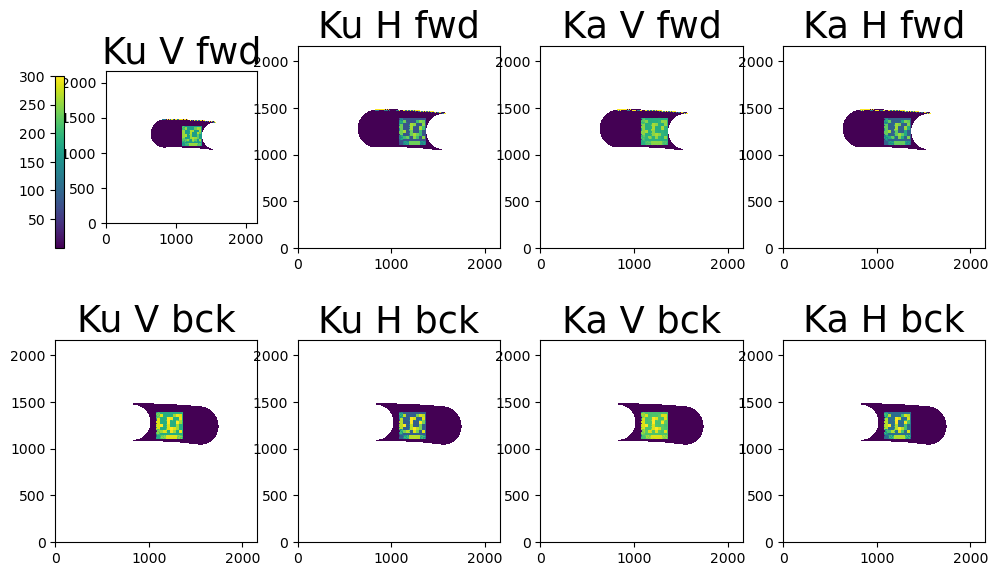

In [13]:
# Plot regridded

ku_v_regrid = fwd_ku_regrid[:, :, 0]

#cmap = cmocean.cm.ice
cmap = cm.viridis
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_regrid[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("Ku V fwd")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_regrid[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax2.set_title("Ku H fwd")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_regrid[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax3.set_title("Ka V fwd")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_regrid[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax4.set_title("Ka H fwd")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_regrid[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax5.set_title("Ku V bck")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_regrid[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax6.set_title("Ku H bck")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_regrid[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax7.set_title("Ka V bck")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_regrid[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax8.set_title("Ka H bck")

fig.colorbar(c1, ax=ax1, location='left', anchor=(0, 0.3), shrink=0.7)

# Step 1d: Laplacian pre-processing


In [14]:
# Laplacian pre-processing
#run_cmcc with the --only_preproc argument

#e.g. ndimage.laplace(image)     (not sure if need filters)

#I found my old software. I was using scipy.ndimage.filters.laplace() with no extra parameters.
#fill_values must first be converted to nans, and back to fill_value after the laplace, e.g. with:


from scipy.ndimage import laplace

# Replaces fill value by NaN and removes mask
def _get_nans(img):
    img_masked = np.ma.asarray(img)
    return img_masked.filled(np.nan)

# Replaces NaN by fill value and a mask
def _mask_nans(img):
    return np.ma.masked_invalid(img)

# Convert fill values to NaNs
fwd_ku_nan = _get_nans(fwd_ku_regrid)
bck_ku_nan = _get_nans(bck_ku_regrid)
fwd_ka_nan = _get_nans(fwd_ka_regrid)
bck_ka_nan = _get_nans(bck_ka_regrid)

# Laplacian transform
fwd_ku_lap = laplace(fwd_ku_nan)
bck_ku_lap = laplace(bck_ku_nan)
fwd_ka_lap = laplace(fwd_ka_nan)
bck_ka_lap = laplace(bck_ka_nan)

# Converting NaNs to fill values
fwd_ku_fv = _mask_nans(fwd_ku_lap)
bck_ku_fv = _mask_nans(bck_ku_lap)
fwd_ka_fv = _mask_nans(fwd_ka_lap)
bck_ka_fv = _mask_nans(bck_ka_lap)

# Creating a flag field
#define TCIMAGE_OUTSIDE_GRID              -2
#define TCIMAGE_NODATA                    -1
#define TCIMAGE_OK                         0
#define TCIMAGE_UNPROCESSED                1
#define TCIMAGE_FAILED                     2
fwd_ku_flag = np.zeros_like(fwd_ku_fv)
bck_ku_flag = np.zeros_like(bck_ku_fv)
fwd_ka_flag = np.zeros_like(fwd_ka_fv)
bck_ka_flag = np.zeros_like(bck_ka_fv)
# Masking where the Laplacian didn't work
fwd_ku_flag[fwd_ku_fv.mask] = -1
bck_ku_flag[bck_ku_fv.mask] = -1
fwd_ka_flag[fwd_ka_fv.mask] = -1
bck_ka_flag[bck_ka_fv.mask] = -1
# Masking where the land and ocean is
landocean = np.logical_or(ie == 9, ie == 1)
fwd_ku_flag[landocean] = 1
bck_ku_flag[landocean] = 1
fwd_ka_flag[landocean] = 1
bck_ka_flag[landocean] = 1

#TODO - The ocean not masked in Landocean (but masked by NODATA, so don't worry now)

In [15]:
print("NaN min, max fwd_ku_regrid = {}, {}".format(np.nanmin(fwd_ku_regrid), np.nanmax(fwd_ku_regrid)))
print("NaN min, max fwd_ku_fv = {}, {}".format(np.nanmin(fwd_ku_fv), np.nanmax(fwd_ku_fv)))

NaN min, max fwd_ku_regrid = 0.03105082879785692, 300.02772195157746
NaN min, max fwd_ku_fv = -1199.9866844911185, 1199.9866844911185


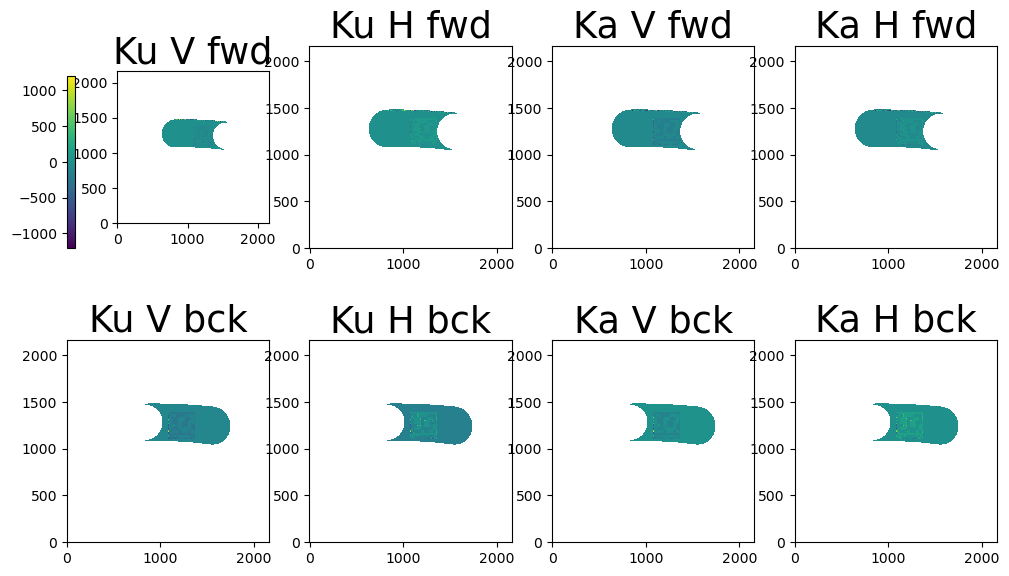

In [15]:
# Plot Laplacian

cmap = cm.viridis
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_fv[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("Ku V fwd")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_fv[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax2.set_title("Ku H fwd")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_fv[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax3.set_title("Ka V fwd")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_fv[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax4.set_title("Ka H fwd")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_fv[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax5.set_title("Ku V bck")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_fv[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax6.set_title("Ku H bck")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_fv[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax7.set_title("Ka V bck")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_fv[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax8.set_title("Ka H bck")

fig.colorbar(c1, ax=ax1, location='left', anchor=(0, 0.3), shrink=0.7)

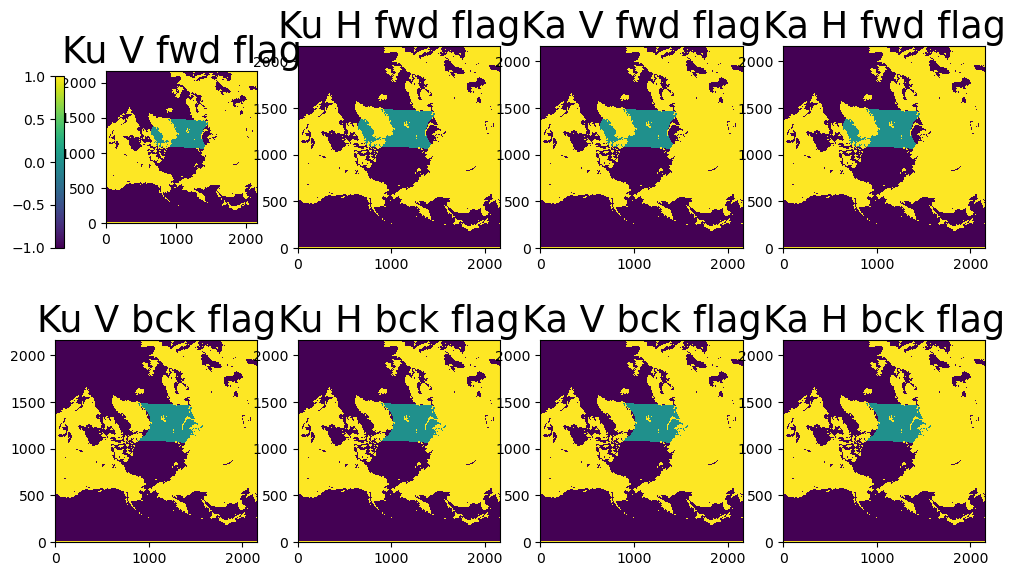

In [101]:
# Plot Laplacian flags

cmap = cm.viridis
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_flag[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("Ku V fwd flag")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_flag[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax2.set_title("Ku H fwd flag")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_flag[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax3.set_title("Ka V fwd flag")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_flag[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax4.set_title("Ka H fwd flag")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_flag[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax5.set_title("Ku V bck flag")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_flag[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax6.set_title("Ku H bck flag")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_flag[:, :, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax7.set_title("Ka V bck flag")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_flag[:, :, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax8.set_title("Ka H bck flag")

fig.colorbar(c1, ax=ax1, location='left', anchor=(0, 0.3), shrink=0.7)

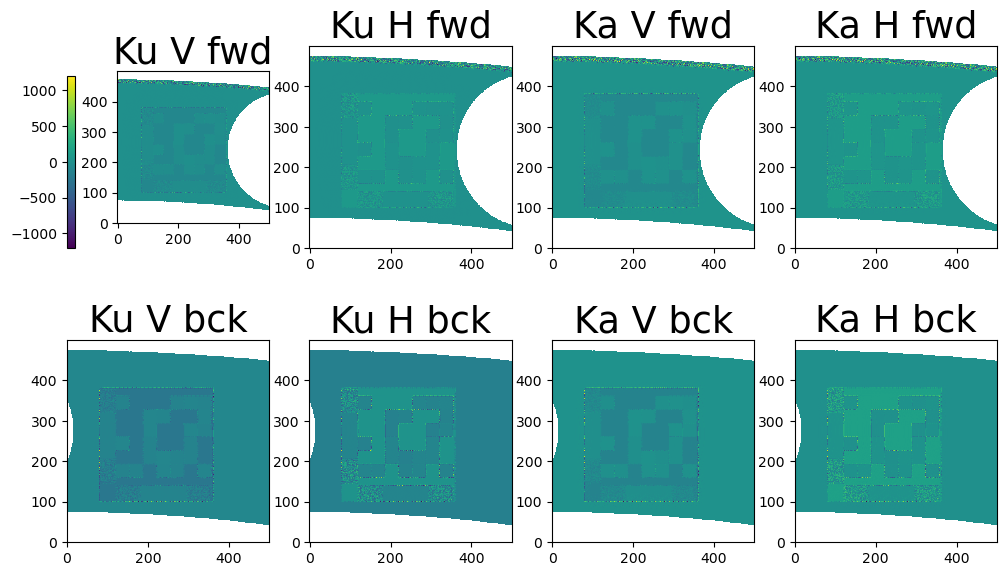

In [16]:
# Plot Laplacian zoomed

cmap = cm.viridis
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,4,1)
c1 = ax1.imshow(fwd_ku_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax1.set_title("Ku V fwd")
ax2 = fig.add_subplot(2,4,2)
c2 = ax2.imshow(fwd_ku_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax2.set_title("Ku H fwd")
ax3 = fig.add_subplot(2,4,3)
c3 = ax3.imshow(fwd_ka_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax3.set_title("Ka V fwd")
ax4 = fig.add_subplot(2,4,4)
c4 = ax4.imshow(fwd_ka_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax4.set_title("Ka H fwd")

ax5 = fig.add_subplot(2,4,5)
c5 = ax5.imshow(bck_ku_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax5.set_title("Ku V bck")
ax6 = fig.add_subplot(2,4,6)
c6 = ax6.imshow(bck_ku_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax6.set_title("Ku H bck")
ax7 = fig.add_subplot(2,4,7)
c7 = ax7.imshow(bck_ka_fv[1000:1500, 1000:1500, 0], interpolation = 'none', origin='lower', cmap=cmap)
ax7.set_title("Ka V bck")
ax8 = fig.add_subplot(2,4,8)
c8 = ax8.imshow(bck_ka_fv[1000:1500, 1000:1500, 1], interpolation = 'none', origin='lower', cmap=cmap)
ax8.set_title("Ka H bck")

fig.colorbar(c1, ax=ax1, location='left', anchor=(0, 0.3), shrink=0.7)

In [47]:
#print(fwd_ku_regrid[1200:1300, 1200:1300, 0]) # So plot for example 150 to 300
#print(bck_ku_regrid[1200:1300, 1200:1300, 0]) # So plot for example 150 to 300
#print(fwd_ka_regrid[1200:1300, 1200:1300, 0]) # So plot for example 150 to 300
#print(bck_ka_regrid[1200:1300, 1200:1300, 0]) # So plot for example 150 to 300

#print(fwd_ku_fv[1200:1300, 1200:1300, 0]) # So plot for example 0 to -100
#print(bck_ku_fv[1200:1300, 1200:1300, 0]) # So plot for example 0 to -100
#print(fwd_ka_fv[1200:1300, 1200:1300, 0]) # So plot for example 0 to -100
#print(bck_ka_fv[1200:1300, 1200:1300, 0]) # So plot for example 0 to -100

[[253.57713328 253.41940633 253.47573738 ... 227.9803015  228.12676224
  228.19435951]
 [253.57713328 253.41940633 253.47573738 ... 227.99156771 228.13802845
  228.19435951]
 [253.41940633 253.41940633 253.47573738 ... 228.13802845 228.13802845
  228.20562572]
 ...
 [265.75590756 265.64324545 265.59818061 ... 166.51185334 166.11753595
  166.11753595]
 [265.75590756 265.64324545 265.59818061 ... 166.46678849 166.46678849
  166.10626973]
 [265.75590756 265.64324545 265.59818061 ... 166.11753595 166.45552228
  166.09500352]]
[[253.37434148 253.50953602 253.34054285 ... 228.14929467 228.25069057
  228.25069057]
 [253.38560769 253.50953602 253.50953602 ... 228.14929467 228.14929467
  228.25069057]
 [253.38560769 253.38560769 253.50953602 ... 228.19435951 228.16056088
  228.25069057]
 ...
 [265.35032396 265.62071303 265.65451166 ... 166.08373731 166.16260079
  165.90347793]
 [265.36159017 265.62071303 265.66577787 ... 166.06120489 166.14006837
  165.90347793]
 [265.37285638 265.63197924 265.

# Step 1e: Writing out the file


In [48]:
#print(fwd_ku_regrid)

In [17]:
#print(new_area_def)
#print(new_lons)
#print(new_lats)
#print(new_area_def.projection_x_coords)
#
#print('------------------------')
#print(new_area_def.__dict__)
#print('========================')
#print(dir(new_area_def))
#print('________________________')
#print(new_area_def.proj4_string)
#print('########################')
#
#print("1", new_area_def.area_id)
#print("2", new_area_def.description)
#print("3", new_area_def.proj_id)
#print("4", new_area_def.projection)
#print("5", new_area_def.width)
#print("6", new_area_def.height)
#print("7", new_area_def.area_extent)
#
#print("----------------")

crs_info = {'proj4_string': new_area_def.proj4_string,
             'area_id': new_area_def.area_id,
             'semi_major_axis': 6378137.,
             'semi_minor_axis': 6356752.31424518,
             'inverse_flattening': 298.257223563,
             'reference_ellipsoid_name': "WGS 84",
             'longitude_of_prime_meridian': 0.,
             'prime_meridian_name': "Greenwich",
             'geographic_crs_name': "unknown",
             'horizontal_datum_name': "World Geodetic System 1984",
             'projected_crs_name': "unknown",
             'grid_mapping_name': "lambert_azimuthal_equal_area",
             'latitude_of_projection_origin': 90.,
             'longitude_of_projection_origin': 0.,
             'false_easting': 0.,
             'false_northing': 0.}

/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [114]:
print(pdate)
print(pdate.timestamp())
print(type(pdate.timestamp()))
print(type(fwd_ku_regrid[50, 50, 0]))

2028-01-10 00:00:00
1831075200.0
<class 'float'>
<class 'numpy.float64'>


In [18]:
ds = xr.Dataset(
    data_vars=dict(
#        fwd_ku=(["xc", "yc", "pol"], fwd_ku_regrid),
#        bck_ku=(["xc", "yc", "pol"], bck_ku_regrid),
#        fwd_ka=(["xc", "yc", "pol"], fwd_ka_regrid),
#        bck_ka=(["xc", "yc", "pol"], bck_ka_regrid),
#        fwd_ku_lap=(["xc", "yc", "pol"], fwd_ku_fv),
#        bck_ku_lap=(["xc", "yc", "pol"], bck_ku_fv),
#        fwd_ka_lap=(["xc", "yc", "pol"], fwd_ka_fv),
#        bck_ka_lap=(["xc", "yc", "pol"], bck_ka_fv),
        tb19vfw=(["xc", "yc"], fwd_ku_regrid[:, :, 0]),
        tb19vbk=(["xc", "yc"], bck_ku_regrid[:, :, 0]),
        tb19hfw=(["xc", "yc"], fwd_ku_regrid[:, :, 1]),
        tb19hbk=(["xc", "yc"], bck_ku_regrid[:, :, 1]),
        tb37vfw=(["xc", "yc"], fwd_ka_regrid[:, :, 0]),
        tb37vbk=(["xc", "yc"], bck_ka_regrid[:, :, 0]),
        tb37hfw=(["xc", "yc"], fwd_ka_regrid[:, :, 1]),
        tb37hbk=(["xc", "yc"], bck_ka_regrid[:, :, 1]),
        tb19vfw_lap=(["xc", "yc"], fwd_ku_fv[:, :, 0]),
        tb19vbk_lap=(["xc", "yc"], bck_ku_fv[:, :, 0]),
        tb19hfw_lap=(["xc", "yc"], fwd_ku_fv[:, :, 1]),
        tb19hbk_lap=(["xc", "yc"], bck_ku_fv[:, :, 1]),
        tb37vfw_lap=(["xc", "yc"], fwd_ka_fv[:, :, 0]),
        tb37vbk_lap=(["xc", "yc"], bck_ka_fv[:, :, 0]),
        tb37hfw_lap=(["xc", "yc"], fwd_ka_fv[:, :, 1]),
        tb37hbk_lap=(["xc", "yc"], bck_ka_fv[:, :, 1]),
        tb19vfw_lap_flag=(["xc", "yc"], fwd_ku_flag[:, :, 0]),
        tb19vbk_lap_flag=(["xc", "yc"], bck_ku_flag[:, :, 0]),
        tb19hfw_lap_flag=(["xc", "yc"], fwd_ku_flag[:, :, 1]),
        tb19hbk_lap_flag=(["xc", "yc"], bck_ku_flag[:, :, 1]),
        tb37vfw_lap_flag=(["xc", "yc"], fwd_ka_flag[:, :, 0]),
        tb37vbk_lap_flag=(["xc", "yc"], bck_ka_flag[:, :, 0]),
        tb37hfw_lap_flag=(["xc", "yc"], fwd_ka_flag[:, :, 1]),
        tb37hbk_lap_flag=(["xc", "yc"], bck_ka_flag[:, :, 1]),
        dtime=(["xc", "yc"], np.full_like(fwd_ku_regrid[:, :, 0], pdate.timestamp())),
        ice_edge=(["xc", "yc"], ie),
        crs=([], 0),
        time=(["xc"], np.full_like(fwd_ku_regrid[:, 0, 0], pdate.timestamp()))
    ),
    #dims=["x", "y", "pol"],
    coords=dict(
        lon=(["xc", "yc"], new_lons),
        lat=(["xc", "yc"], new_lats),
        #pol=["V", "H"]
        #time=time,
        #reference_time=reference_time,
    ),
    attrs=dict(description="Variables for CMCC",
               datetime=datetime.strftime(pdate, '%Y%m%d')),
)
ds['xc'] = new_area_def.projection_x_coords
ds['xc'].attrs = {'units': 'm'}
ds['yc'] = new_area_def.projection_y_coords
ds['yc'].attrs = {'units': 'm'}
ds['crs'].attrs = crs_info
ds['dtime'].attrs = {'units': "seconds since 1970-01-01 00:00:00"}
ds['time'].attrs = {'units': "seconds since 1970-01-01 00:00:00"}
#print(ds)

#da = xr.DataArray(
#    data=fwd_ku_regrid,
#    dims=["x", "y", "pol"],
#    coords=dict(
#        lon=(["x", "y"], new_lons),
#        lat=(["x", "y"], new_lats),
#        pol=["V", "H"]
#    ),
#    attrs=dict(
#        description="Ambient temperature.",
#        units="degC",
#    ),
#)

#da.to_netcdf('/home/emilyjd/cimr-devalgo/test/fwd_ku_regrid.nc', 'w')
dsname = '/home/emilyjd/cimr-devalgo/data/swaths/bt_{}_{}.nc'.format(gridname, datetime.strftime(pdate, '%Y%m%d'))
ds.to_netcdf(dsname, 'w', format="NETCDF3_CLASSIC")
print("--", ds.tb19vfw.data.shape)
ds.tb19vfw.data[1200:1205, 1200:1205]

-- (2160, 2160)


array([[253.57713328, 253.41940633, 253.47573738, 253.47573738,
        253.56586707],
       [253.57713328, 253.41940633, 253.47573738, 253.56586707,
        253.56586707],
       [253.41940633, 253.41940633, 253.47573738, 253.56586707,
        253.50953602],
       [253.41940633, 253.47573738, 253.47573738, 253.56586707,
        253.50953602],
       [253.41940633, 253.47573738, 253.56586707, 253.56586707,
        253.52080223]])

### Step 1f (temporary): Creating a test gridded file with "time difference" 24h and 1 px added in each x and y


In [19]:
# Use an xarray to make it easy to shift the data
#ds = xr.open_dataset(dsname)
#print(ds)

## Shift can be used in xarray to shift dimension by number of pix. Note that the dimensions must be called x and y within xarray
#fwd_ku_shft = ds.fwd_ku.shift(xc=1, yc=1)
#bck_ku_shft = ds.bck_ku.shift(xc=1, yc=1)
#fwd_ka_shft = ds.fwd_ka.shift(xc=1, yc=1)
#bck_ka_shft = ds.bck_ka.shift(xc=1, yc=1)
#fwd_ku_lap_shft = ds.fwd_ku_lap.shift(xc=1, yc=1)
#bck_ku_lap_shft = ds.bck_ku_lap.shift(xc=1, yc=1)
#fwd_ka_lap_shft = ds.fwd_ka_lap.shift(xc=1, yc=1)
#bck_ka_lap_shft = ds.bck_ka_lap.shift(xc=1, yc=1)
##print(fwd_ku_shft.shape)
##print(ds['fwd_ku'].data)
#ds['fwd_ku'].data = fwd_ku_shft
#ds['bck_ku'].data = bck_ku_shft
#ds['fwd_ka'].data = fwd_ka_shft
#ds['bck_ka'].data = bck_ka_shft
#ds['fwd_ku_lap'].data = fwd_ku_lap_shft
#ds['bck_ku_lap'].data = bck_ku_lap_shft
#ds['fwd_ka_lap'].data = fwd_ka_lap_shft
#ds['bck_ka_lap'].data = bck_ka_lap_shft

# Shift can be used in xarray to shift dimension by number of pix. Note that the dimensions must be called x and y within xarray
tb19vfw_shft = ds.tb19vfw.shift(xc=1, yc=1)
tb19vbk_shft = ds.tb19vbk.shift(xc=1, yc=1)
tb19hfw_shft = ds.tb19hfw.shift(xc=1, yc=1)
tb19hbk_shft = ds.tb19hbk.shift(xc=1, yc=1)
tb37vfw_shft = ds.tb37vfw.shift(xc=1, yc=1)
tb37vbk_shft = ds.tb37vbk.shift(xc=1, yc=1)
tb37hfw_shft = ds.tb37hfw.shift(xc=1, yc=1)
tb37hbk_shft = ds.tb37hbk.shift(xc=1, yc=1)
tb19vfw_lap_shft = ds.tb19vfw_lap.shift(xc=1, yc=1)
tb19vbk_lap_shft = ds.tb19vbk_lap.shift(xc=1, yc=1)
tb19hfw_lap_shft = ds.tb19hfw_lap.shift(xc=1, yc=1)
tb19hbk_lap_shft = ds.tb19hbk_lap.shift(xc=1, yc=1)
tb37vfw_lap_shft = ds.tb37vfw_lap.shift(xc=1, yc=1)
tb37vbk_lap_shft = ds.tb37vbk_lap.shift(xc=1, yc=1)
tb37hfw_lap_shft = ds.tb37hfw_lap.shift(xc=1, yc=1)
tb37hbk_lap_shft = ds.tb37hbk_lap.shift(xc=1, yc=1)
tb19vfw_lap_flag_shft = ds.tb19vfw_lap_flag.shift(xc=1, yc=1)
tb19vbk_lap_flag_shft = ds.tb19vbk_lap_flag.shift(xc=1, yc=1)
tb19hfw_lap_flag_shft = ds.tb19hfw_lap_flag.shift(xc=1, yc=1)
tb19hbk_lap_flag_shft = ds.tb19hbk_lap_flag.shift(xc=1, yc=1)
tb37vfw_lap_flag_shft = ds.tb37vfw_lap_flag.shift(xc=1, yc=1)
tb37vbk_lap_flag_shft = ds.tb37vbk_lap_flag.shift(xc=1, yc=1)
tb37hfw_lap_flag_shft = ds.tb37hfw_lap_flag.shift(xc=1, yc=1)
tb37hbk_lap_flag_shft = ds.tb37hbk_lap_flag.shift(xc=1, yc=1)

ds['tb19vfw'].data = tb19vfw_shft
ds['tb19vbk'].data = tb19vbk_shft
ds['tb19hfw'].data = tb19hfw_shft
ds['tb19hbk'].data = tb19hbk_shft
ds['tb37vfw'].data = tb37vfw_shft
ds['tb37vbk'].data = tb37vbk_shft
ds['tb37hfw'].data = tb37hfw_shft
ds['tb37hbk'].data = tb37hbk_shft
ds['tb19vfw_lap'].data = tb19vfw_lap_shft
ds['tb19vbk_lap'].data = tb19vbk_lap_shft
ds['tb19hfw_lap'].data = tb19hfw_lap_shft
ds['tb19hbk_lap'].data = tb19hbk_lap_shft
ds['tb37vfw_lap'].data = tb37vfw_lap_shft
ds['tb37vbk_lap'].data = tb37vbk_lap_shft
ds['tb37hfw_lap'].data = tb37hfw_lap_shft
ds['tb37hbk_lap'].data = tb37hbk_lap_shft
ds['tb19vfw_lap_flag'].data = tb19vfw_lap_flag_shft
ds['tb19vbk_lap_flag'].data = tb19vbk_lap_flag_shft
ds['tb19hfw_lap_flag'].data = tb19hfw_lap_flag_shft
ds['tb19hbk_lap_flag'].data = tb19hbk_lap_flag_shft
ds['tb37vfw_lap_flag'].data = tb37vfw_lap_flag_shft
ds['tb37vbk_lap_flag'].data = tb37vbk_lap_flag_shft
ds['tb37hfw_lap_flag'].data = tb37hfw_lap_flag_shft
ds['tb37hbk_lap_flag'].data = tb37hbk_lap_flag_shft

# Shift time by 24h
qdate = pdate + timedelta(days=1)
ds.attrs['datetime'] = datetime.strftime(qdate, '%Y%m%d')
ds['dtime'].data = np.full_like(fwd_ku_regrid[:, :, 0], qdate.timestamp())
ds['time'].data = np.full_like(fwd_ku_regrid[:, 0, 0], qdate.timestamp())

dsname2 = '/home/emilyjd/cimr-devalgo/data/swaths/bt_{}_{}.nc'.format(gridname, datetime.strftime(qdate, '%Y%m%d'))
ds.to_netcdf(dsname2, 'w', format="NETCDF3_CLASSIC")
print("--", ds.tb19vfw.data.shape)
ds.tb19vfw.data[1200:1205, 1200:1205]

-- (2160, 2160)


array([[253.46447117, 253.57713328, 253.41940633, 253.41940633,
        253.46447117],
       [253.57713328, 253.57713328, 253.41940633, 253.47573738,
        253.47573738],
       [253.57713328, 253.57713328, 253.41940633, 253.47573738,
        253.56586707],
       [253.57713328, 253.41940633, 253.41940633, 253.47573738,
        253.56586707],
       [253.57713328, 253.41940633, 253.47573738, 253.47573738,
        253.56586707]])

## Step 2: Cross-correlation algorithm


In [ ]:
### Step 2a: Select the pixels which can be cross-correlated


In [44]:
# (1) Mask the land
# (2) Mask the pixels which are not over ice in both the start and end images
# (3) Mask pixels where the start or end images are missing data

# Ice mask notation
# 0 - Open water/missing
# 3 - Open/close ice
# 9 - Land

#validpix = 

### Step 2b: CMCC


In [20]:
# Ku - 18.7
# Ka - 36.5 GHz
# Copying the files with new names
chanstr = 'tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk'
newname1 = 'tc_wght_cimr-cimr_{}_{}-ease2-050_{}12.nc'.format(chanstr, hemi, datetime.strftime(pdate, '%Y%m%d'))
newname2 = 'tc_wght_cimr-cimr_{}_{}-ease2-050_{}12.nc'.format(chanstr, hemi, datetime.strftime(qdate, '%Y%m%d'))
shutil.copyfile(dsname, os.path.join(os.path.dirname(dsname), newname1))
shutil.copyfile(dsname2, os.path.join(os.path.dirname(dsname), newname2))


'/home/emilyjd/cimr-devalgo/data/swaths/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc'

In [27]:
%load_ext autoreload
%autoreload
from icedrift_wrapper import icedrift_wrapper

# TO DO - ADD GRID NEEDED TO pmr_gridding/etc/grids.def
#run_cmcc.py
chan_list = ['tb19hfw_lap']
icedrift_wrapper(pdate, qdate, '/home/emilyjd/cimr-devalgo/data/swaths', '/home/emilyjd/cimr-devalgo/data/swaths',
                 '/home/emilyjd/cimr-devalgo/data/ice_drift', '/home/emilyjd/cimr-devalgo/data/logs/cmcc-test.log',
                 'cimr-cimr', 'nh-ease2-050', chan_list, 75., 100.)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Daily maps found (cimr-cimr):

	Day 1 : /home/emilyjd/cimr-devalgo/data/swaths/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011012.nc 

	Day 2 : /home/emilyjd/cimr-devalgo/data/swaths/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc 





/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


NameError: name 'ffi' is not defined

In [48]:
# Will need to alter icedrift code so that the forward and backward scans are treated the same as the 
# H and V polarisations, and combined within the drift algorithm. Note that the forward and backward scans are 
# actually separated by 7 minutes, so later on we can try to use the time shift between these too.

## Step 3: Detection and correction of rogue vectors
